# Simulação de Monte Carlo e Black & Scholes

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sts
import matplotlib.pyplot as plt
import yahoo_fin.stock_info as si
import warnings
import time

warnings.filterwarnings('ignore')

## Funções

In [2]:
# Ler dados histórico do ativo
def read_fx_input_modificado(fx_name, data_fim): #Função da aula modificada para data fim
    df = si.get_data(fx_name, end_date = data_fim, index_as_date = True, interval = '1d')
    df = df.loc[:,['adjclose']]
    df.columns = ['price']
    return df

#------------------------------

# Calcula retorno e pnl
def calc_ret_pnl(df, hp): 
    df['return'] = (df['price']/df['price'].shift(hp) - 1) # Retorno
    df['PnL'] = df['price'] - df['price'].shift(hp) # Realizado
    return df[hp:]

#------------------------------

# Consulta de dados do Banco Central (professor Henrique)
def consulta_bcb(codigo_bcb, dt_ini = '04/01/2005', dt_fin = '04/03/2022'):
    url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json&dataInicial={}&dataFinal={}'.format(codigo_bcb, dt_ini, dt_fin)

    df = pd.read_json(url)
    df['data'] = pd.to_datetime(df['data'], dayfirst=True)
    
    return df

#------------------------------

# Calculo do Black & Scholes
def calc_BS(S, K, r, T, sigma, tipo):
    # Cálculo do d1
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / sigma*np.sqrt(T)
    # Cálculo do d2
    d2 = d1 - sigma*np.sqrt(T)
    
    if tipo == 'call':
        # Preço se for call (opção de compra)
        price = S*sts.norm.cdf(d1) - K*np.exp(-r*T)*sts.norm.cdf(d2)
    elif tipo == 'put':
        # preço se for put (opção de venda)
        price = K*np.exp(-r*T)*sts.norm.cdf(-d2) - S*sts.norm.cdf(-d1)
    else:
        # Não sei o tipo, não calculo
        price = None
    
    return price # Preço/prêmio


## Funções criadas para esse trabalho

In [3]:
def calc_gbm(S0, mu, sigma, T, n_steps):
    ''' Calcula GBM '''
    y = [S0] # inicializa a sequencia com o preço do ativo hoje
    dT = T / n_steps
    mu_dT = mu * dT # multiplica o retorno pelo dT
    sigma_raiz_dT = sigma * np.sqrt(dT) # multiplica o risco por raiz quadrada de dT
    
    for t in range(n_steps):
        # Equação do GBM (novo valor é o que está sendo inserido da lista pelo método append)
        # (o valor antigo para calcular o novo valor é y[t], pois t é o último valor da lista antes do novo append)
        y.append(y[t] + y[t] * (mu_dT + sigma_raiz_dT * np.random.normal())) 
        
    return y

#------------------------------

def calc_abm(S0, mu, sigma, T, n_steps):
    ''' Calcula ABM '''
    y = [S0]    # inicializa a sequencia com o preço do ativo hoje
    dT = T / n_steps 
    mu_dT = mu * dT  # multiplica o retorno pelo dT
    sigma_raiz_dT = sigma * np.sqrt(dT) # multiplica o risco por raiz quadrada de dT

    for t in range(n_steps):
        y.append(y[t] + mu_dT + sigma_raiz_dT * np.random.normal()) # Equação do ABM
        
    return y

#------------------------------

def monte_carlo(S0, mu, sigma, T, n_steps, N, tipo):
    ''' Retorna um DataFrame onde cada coluna é uma trajetória aleatória; 
        A quantidade de registros do DataFrame é o tamanho das trajetórias '''
    df = pd.DataFrame()
    
    if tipo == 'GBM':
        for i in range(N):
            df[i] = calc_gbm(S0, mu, sigma, T, n_steps)
            
    elif tipo == 'ABM':
        for i in range(N):
            df[i] = calc_abm(S0, mu, sigma, T, n_steps)
    else:
        print('Tipos: "GBM" ou "ABM"')
        
    return df

## Movimento Browniano Geométrico e do Movimento Browniano Aritimético

**Como não sabemos qual janela de tempo escolher para calibrar o risco do ativo, usaremos todo o histórico do ativo**

In [4]:
ticker = 'VALE3.SA'
data_final = '04/03/2022'
historico = read_fx_input_modificado(ticker, data_final) #Lê o histórico do ativo

periodo = 1
retorno_ativo = calc_ret_pnl(historico,periodo) # Calcula retorno

sigma_1_ano = retorno_ativo['return'].std()*252**(0.5) # Calcula o desvio padrão do retorno diario e anualiza
sigma_1_ano

0.40818927955885764

In [5]:
# Taxa de juros - CDI anualizada base 252, frequencia diaria - Codigo: 4389
CDI = consulta_bcb(4389, dt_ini = '03/03/2022', dt_fin = '04/03/2022')['valor'][0] #CDI anual
CDI = CDI/100 # taxa livre de risco brasileira

# Parametros
S0 = historico.iloc[-1]['price'] #preco do ativo no ultimo dia útil
mu = CDI
sigma = sigma_1_ano
T = 1
n_steps = 252

print(f' S0: R${round(S0,2)}\n mu: {round(mu,4)}\n sigma: {round(sigma,4)}')

 S0: R$102.18
 mu: 0.1065
 sigma: 0.4082


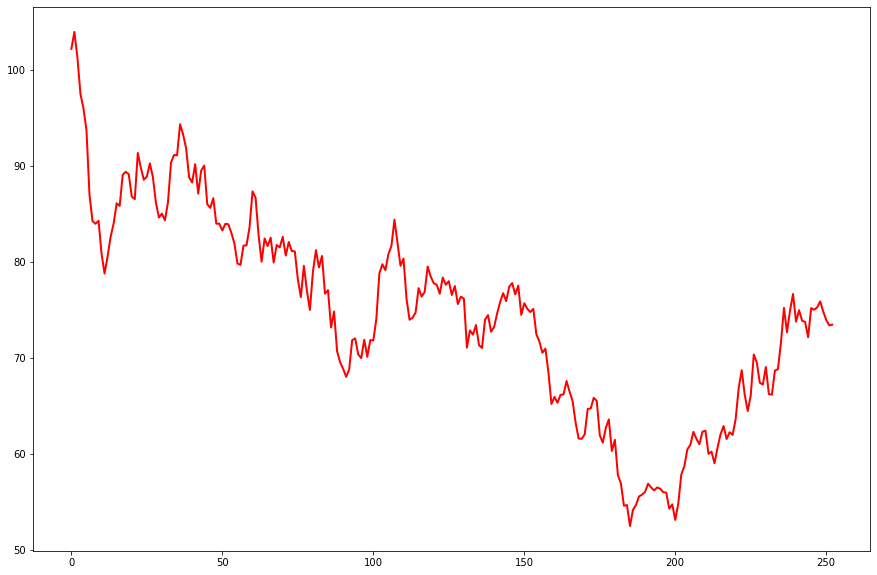

In [6]:
#GBM
gbm1 = calc_gbm(S0, mu, sigma, T, n_steps)

plt.figure(figsize=(15,10))
plt.plot(range(len(gbm1)), gbm1, 'k-', lw=2, label='Normal', color='red');

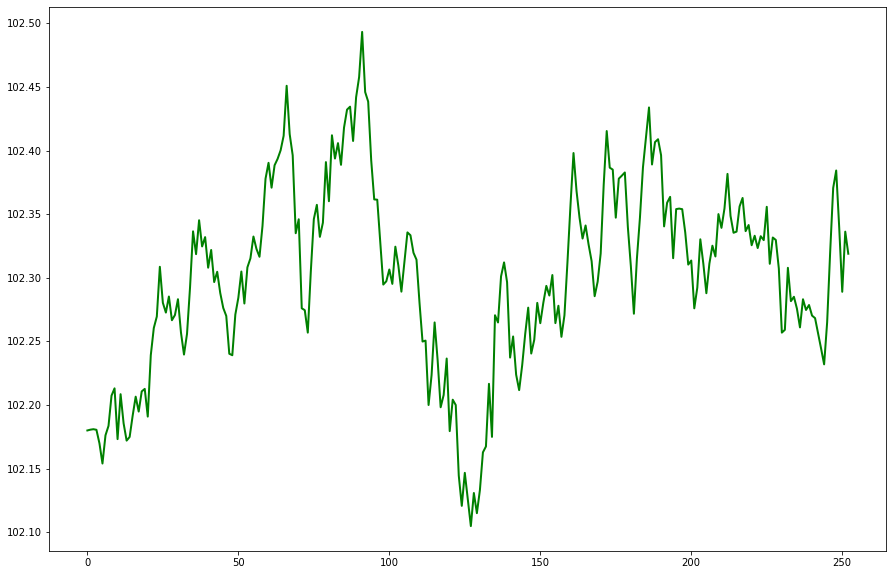

In [7]:
#ABM
abm1 = calc_abm(S0, mu, sigma, T, n_steps)

plt.figure(figsize=(15,10))
plt.plot(range(len(abm1)), abm1, 'k-', lw=2, label='Normal', color='green');

## Monte Carlo

Tempo de execução: 10.8 segundos


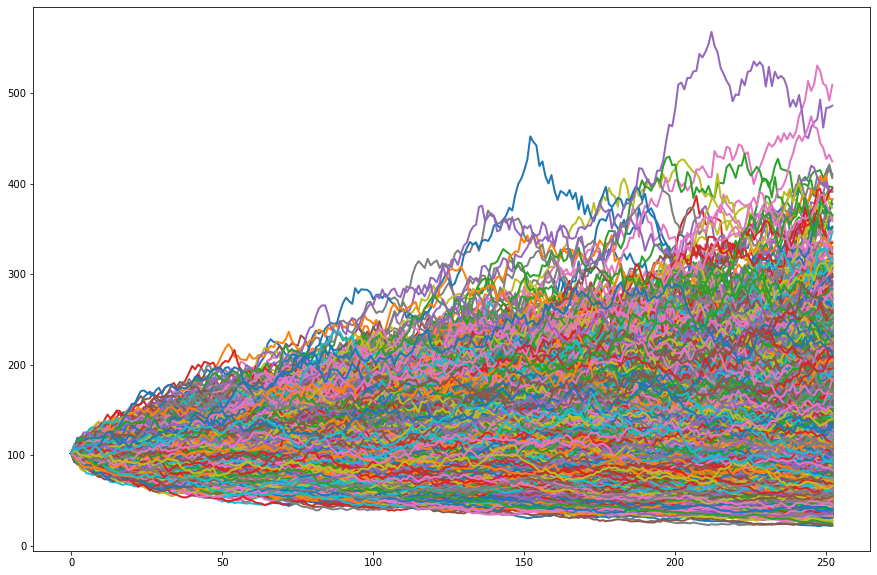

In [8]:
# Monte Carlo com GBM
start_time = time.time()
monte_GBM = monte_carlo(S0, mu, sigma, T, n_steps, 10000, 'GBM')
print(f'Tempo de execução: {round(time.time() - start_time,1)} segundos')

plt.figure(figsize=(15,10));
plt.plot(monte_GBM.index, monte_GBM, lw=2, label='Normal');

Tempo de execução: 11.3 segundos


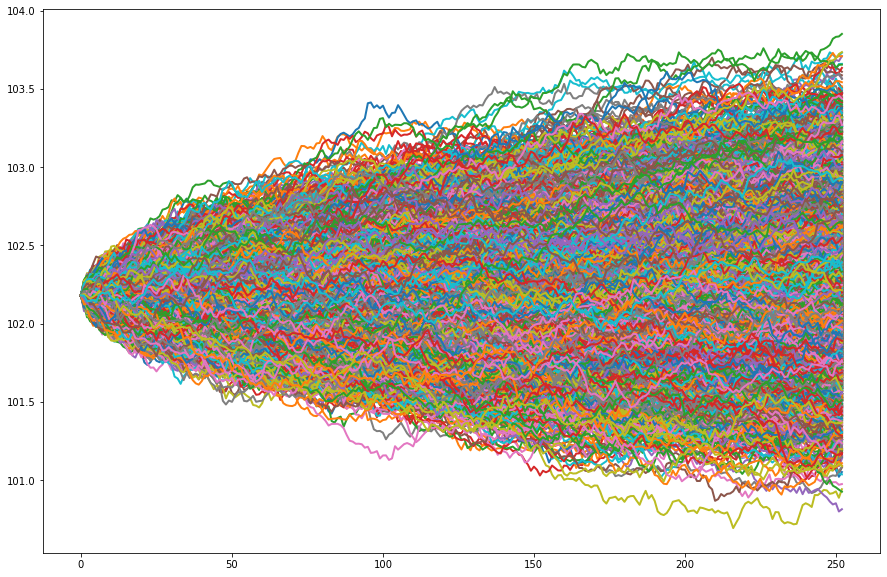

In [9]:
# Monte Carlo com ABM
start_time = time.time()
monte_ABM = monte_carlo(S0, mu, sigma, T, n_steps, 10000, 'ABM')
print(f'Tempo de execução: {round(time.time() - start_time,1)} segundos')

plt.figure(figsize=(15,10));
plt.plot(monte_ABM.index, monte_ABM, lw=2, label='Normal');

## Comparar a trajetória média dentre as simuladas com o preço do ativo levado a valor futuro

In [10]:
preco_livre_risco = S0*(1+CDI)

precos_simulados = monte_GBM.iloc[-1] # ultima linha do DataFrame (10000 preços simulados depois de 252 passos)
preco_esperado = precos_simulados.mean() #Média dos 10000 preços futuros

print(f'Valor futuro (1 ano) livre de risco: R${round(preco_livre_risco,2)}\nPreço esperado pela simulação de Monte Carlo: R${round(preco_esperado,2)}')

Valor futuro (1 ano) livre de risco: R$113.06
Preço esperado pela simulação de Monte Carlo: R$113.78


**Como a média utilizada no Monte Carlo é a taxa CDI, o preço esperado convergiu para o preço do ativo levado a valor futuro pelo CDI**

## Cálculo do payoff de uma opção européia com strike $K$ em cima do ativo simulado

In [11]:
K = S0 # Strike igual ao Spot por sugestão do professor Henrique para comparar com o preço do derivativo utilizando Black & Scholes
payoffs = np.array([])
for preco_futuro in precos_simulados:
    payoffs = np.append(payoffs, [max(K - preco_futuro, 0)]) # Payoff de uma put
    
payoff_esperado = payoffs.mean()
payoff_esperado

12.287676301618784

In [12]:
preco_opcao = payoff_esperado/(1+CDI)  #Traz o payoff a valor presente
preco_opcao

11.104994398209476

## Black-Scholes vs preço simulado

In [13]:
prazo = 1
preco_BS = calc_BS(S0, K, CDI, prazo, sigma, 'put')

print(f'Preço pela simulação R${round(preco_opcao,2)}\nPreço por Black & Scholes R${round(preco_BS,2)}')

Preço pela simulação R$11.1
Preço por Black & Scholes R$11.05


**Black & Scholes calcula bem com K = S0 ou próximo de S0. Isso foi confirmado pela simulação de Monte Carlo**

## Cálculo do VaR e do ES 

In [14]:
n_conf = 0.95
alpha = 1 - n_conf
retorno_trajetorias = precos_simulados - S0

In [15]:
var = (retorno_trajetorias).quantile(alpha)
print(f'Há uma probabilidade de {alpha*100:.2f}% que o ativo perca mais de R${- var:.2f} dentro do próximo ano')

Há uma probabilidade de 5.00% que o ativo perca mais de R$48.73 dentro do próximo ano


In [16]:
es = retorno_trajetorias[retorno_trajetorias <= var].mean()
print(f'O valor esperado de queda do ativo é de R${- es:.2f} caso aconteça o estouro do VaR dentro do próximo ano')

O valor esperado de queda do ativo é de R$56.28 caso aconteça o estouro do VaR dentro do próximo ano
